### Altimeter Setting - Analysis w. Lattice Krig ###

This notebook demonstrates how publicly acessible pressure observations from airports (METARs) and amateur/personal weather stations (MESONETs) can be leveraged to create a high-resolution spatial analysis of sea level pressure (i.e., altimeter setting). The notebook should take between 5-10 minutes to run on a reasonably powerful desktop.

   1) Necessary packages are loaded, a bounding box for the analysis is chosen, and the date of the analysis is specified

   2) Observations within a 5-min window of the selected date are retrieved from a NetCDF file and plotted for visual inspection

   3) Static fields from the High Resolution Rapid Refresh (HRRR) model are retrieved for use as covariates. These analyses are overlayed on the observations producing point       estimates of covariates for Kriging. For pressure, elevation is a good covariate. HRRR terrain elevation is displaye for visualization

   4) The LatticeKrig package (Nychka et al., 2015) - (citation below) is used to generate an analysis of surface pressure. The number of basis centers (NC) is set to 75 and       the number of levels (resolutions) is set to 2. This setting balances performance (run-time) and accuracy (analysis error).

   5) Conditional simulations are performed to estimate the uncertainty (i.e., prediction error) of the LatticeKrig analysis generated in (4).

   6) LatticeKrig analyses and prediction error estimates are written to a NetCDF file for access and visualization with Python.
   
###### Lattice Krigging Citation: (For details see paper available at: https://doi.org/10.1080/10618600.2014.914946) NYCHKA, D., BANDYOPADHYAY, S., HAMMERLING, D., LINDGREN, F. and SAIN, S. (2015). A multiresolution Gaussian process model for the analysis of large spatial datasets. Journal of Computational and Graphical Statistics 24 579–599.

In [1]:
###--------(1)--------###
#Increase width of notebook
IRdisplay::display_html('<style>.container { width:100% !important; }</style>')

#Load relevant libraries
library("dplyr")
library("abind")
library("gridExtra")
library("sp")
library("ncdf4")
library("ggplot2")
library("spam64")
library("raster")
library("fields")
library("LatticeKrig")
library("pals")

#Define data and observation type
sdate <- "20180515_2035"
otyp <- "altimeter"

#Define bounding box for data (typically covers central and eastern U.S. from -105 W to -70 W and 25 N to 50 N) - smaller bounding box here for quick demo purposes
minLng = -105.5
maxLng = -70.5
minLat = 28.5
maxLat = 48.5

#Determine number of grid points in x-y direction
nxx = (maxLng-minLng)/0.05
nyy = (maxLat-minLat)/0.05

#Format the time/date for filenaming
start <- as.POSIXlt(sdate,format="%Y%m%d_%H%M")
date <- format(start, "%Y%m%d_%H%M")
day <- format(start, "%Y%m%d")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘raster’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

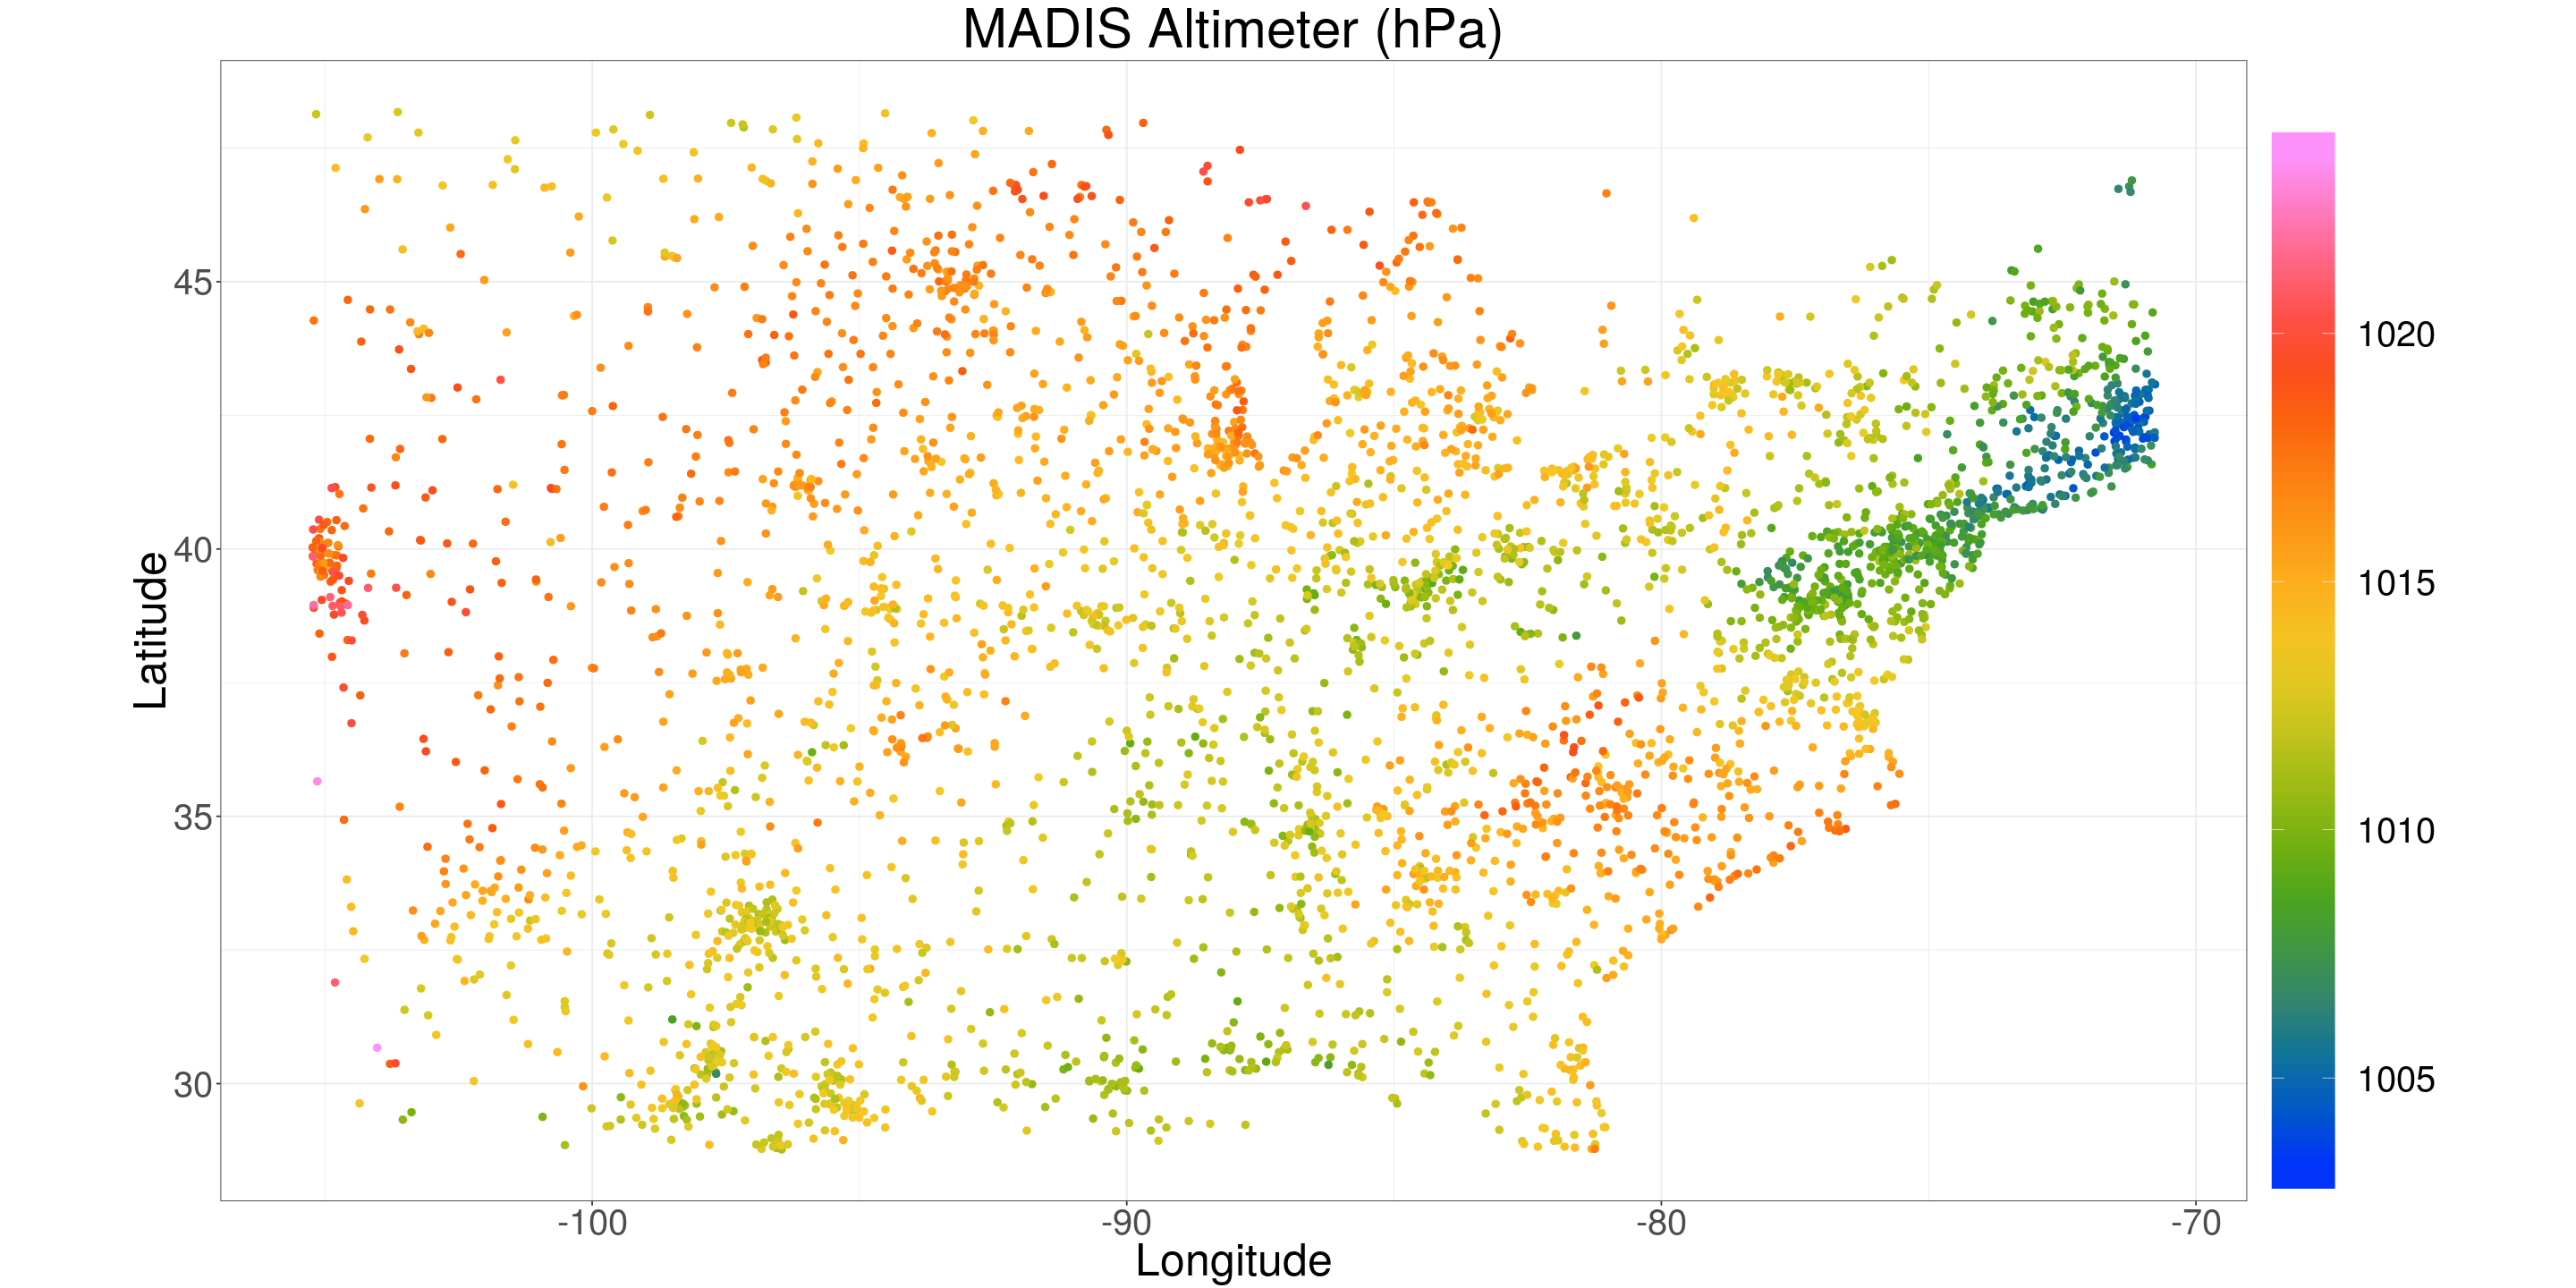

In [2]:
###--------(2)--------###

#Define plot width/height
library(repr)
options(repr.plot.width=24, repr.plot.height=12)

#########################################################
#Retrieve observations within a 5-min window centered at sdate
nc2 <- nc_open(paste("../../../data/Kriging/",otyp,"_pub_",date,".nc",sep=""))
x0 <- ncvar_get(nc2, "longitude") #Retrieve observation longitude
y0 <- ncvar_get(nc2, "latitude") #Retrieve observation latitude
dt <- ncvar_get(nc2,"observationTime") #Retrieve observation time
f1 <- ncvar_get(nc2, "Folds") #Retrieve integer labels (1-4) which have been applied to select obs for cross-validation
vvar0 <- ncvar_get(nc2,otyp) #Retrieve observation value

#Make a dataframe
dfmadis <- data.frame(Date = c(dt)) #Add the date
dfmadis$Date <- as.POSIXct(dfmadis$Date, format="%Y-%m-%d %H:%M:%S") #Format the date
dfmadis$x <- c(x0) #Add the longitude
dfmadis$y <- c(y0) #Add the latitude
dfmadis$f1 <- c(f1) #Add the cross-validation fold # (integer between 1-4) - Folds are divided evenly among stations (i.e. each fold has roughly the same number of unique stations). 
#Since stations report observations at different frequencies the number of observations in each fold may vary.
dfmadis$obs <- c(vvar0) #Add the observation variable

#Subset the data to fall within the bounding box specified above
dfmadis <- subset(dfmadis, y>=minLat & y<=maxLat & x>=minLng & x<=maxLng)

#Remove observations within Fold 1 from analysis so they may be used for verification during cross-validation
#dfmadis_verif <- subset(dfmadis, f1==1)
#dfmadis <- subset(dfmadis, f1!=1)

#Combine latitude,longitude arrays into a matrix and add it to the dataframe
dfmadis$lon.lat <- matrix(c(dfmadis$x,dfmadis$y),nrow=length(dfmadis$x))

#Convert observation dataframe to spatialpoints dataframe
coords1 <- dfmadis[ , c("x", "y")]   # set coordinate variables
crs0 <- CRS("+init=epsg:4326 +proj=longlat") # Define the data projection
spdf_obs <- SpatialPointsDataFrame(coords = coords1, data = dfmadis, proj4string=crs0)

#Plot Observations (Altimeter -> surface pressure corrected to sea level assuming a constant lapse rate - i.e. constant change in temperature w. height)
g1<- ggplot(aes(x, y, color=obs),data=dfmadis) + labs(colour = "") + xlab("Longitude") + ylab("Latitude") + geom_point(size=2) + theme_bw() + theme(text = element_text(size=30), legend.position = "right", legend.key.width = unit(1.5,"cm"), legend.key.height = unit(5, "cm"), plot.title=element_text(hjust=0.5)) + ggtitle("MADIS Altimeter (hPa)") + coord_equal() + scale_color_gradientn(colours=kovesi.rainbow_bgyrm_35_85_c71(100))
g1

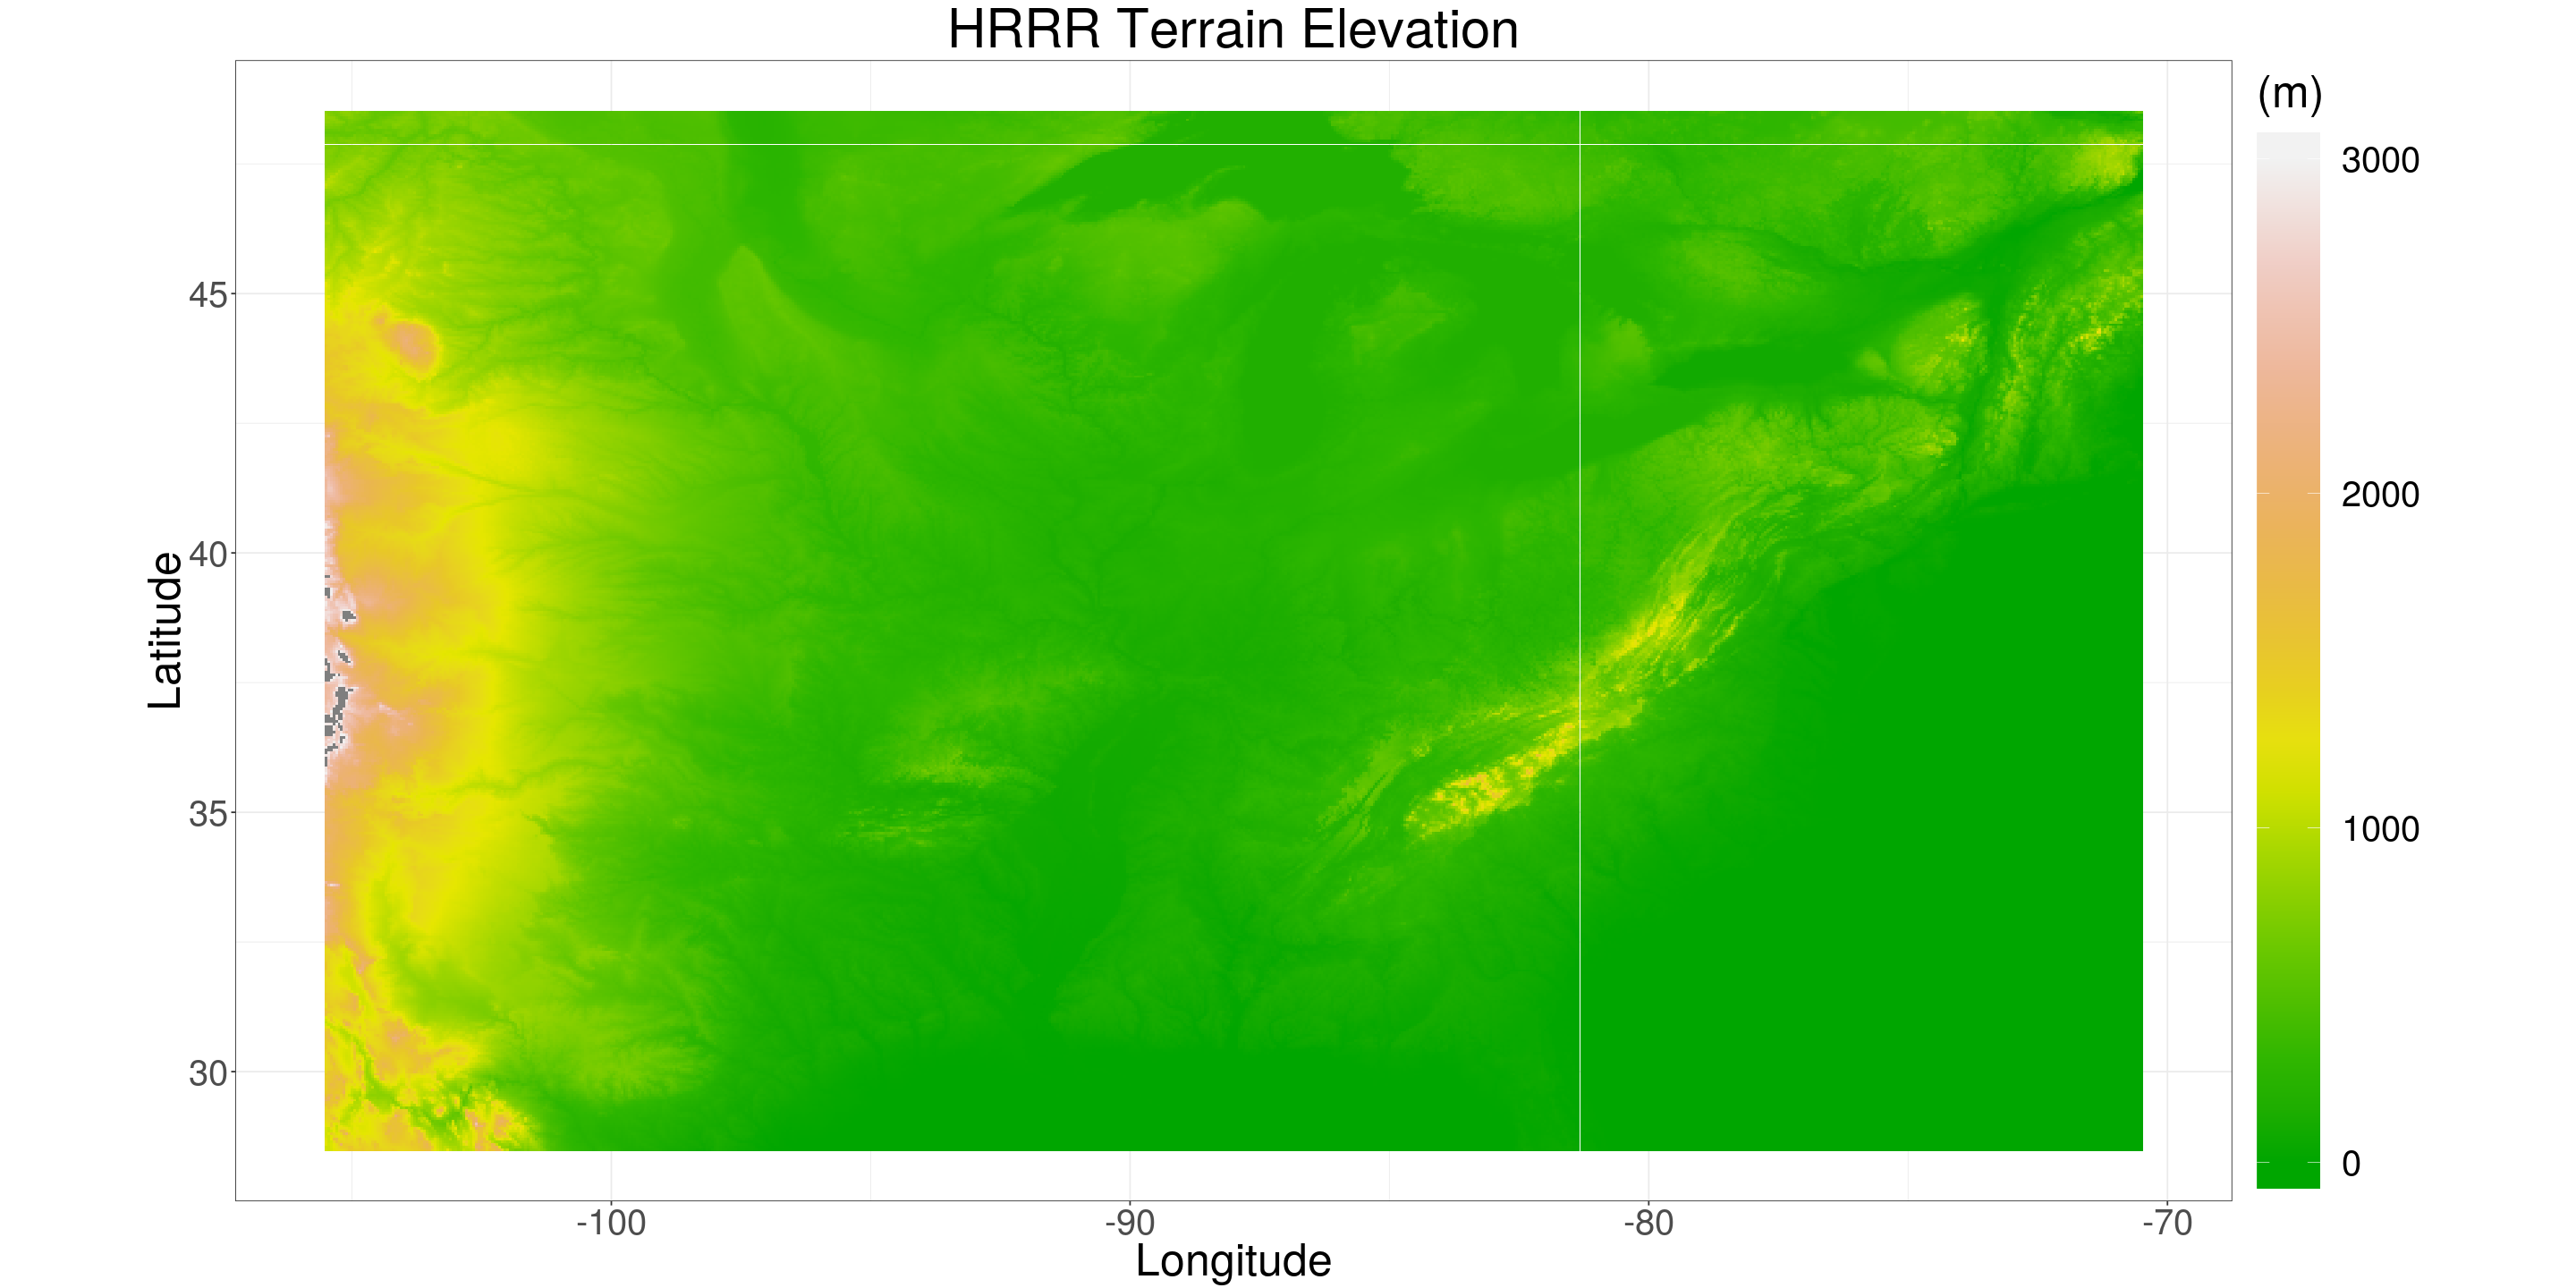

In [3]:
# --------(3)--------###
#############################################################
#Retrieve covariates from state-of-the-art High Resolution Rapid Refresh (HRRR) model analysis
#Note that HRRR model analyses have been linearly interpolated in time (from hourly ouptut to 5-min output)

#Retrieve HRRR model static fields. Convert raster brick to SpatialPixelsDataFrame
r0 <- brick("../../../data/Static/hrrr_static.nc")
#Add coordinate reference
AAs <- as(r0, "SpatialPixelsDataFrame")
crs(AAs)<-crs0

#Overlay the HRRR model analysis at the observation locations
spv0<-over(spdf_obs,AAs)
#Convert HRRR model analysis to dataframe
rdf <- as.data.frame(AAs)
#round the latitude and longitude to the nearest hundreth of a degree (should be spaced at intervals of 0.05 deg)
rdf$x <- round(rdf$x,2) 
rdf$y <- round(rdf$y,2) 
#Subset the HRRR model analysis to eliminte gridpoints beyond the observation bounding box
rdf <- subset(rdf, y>=minLat & y<=maxLat & x>=minLng & x<=maxLng)

#Generate a list of x-coordinates (this matches the HRRR analysis)
xu= seq( minLng,maxLng,,nxx+1)
#Generate a list of y-coordinates (this matches the HRRR analysis)
yu= seq( minLat,maxLat,,nyy+1)
#Create a list of x,y coordinates
glist <- list(x=xu,y=yu)
#Create a surface using the LatticeKrig/Fields package
lGrid <- make.surface.grid(glist)

#Define a function to convert 1-d arrays in the HRRR analysis dataframe to 2-d matrices that have been rotated to the correct N-S orientation
getcov <- function(arr,l1,l2,ggrid) {
        #Convert array to matrix with l1 rows and l2 columns
        arrmat=matrix(arr,nrow=l1,ncol=l2)
        #Create a surface from this matrix
        arrgrid<- as.surface( ggrid, arrmat)
        #Adjust the 2-D grid to the correct orientation (storage in NetCDF is different than in R dataframe)
        arrgrid$z <- apply(arrgrid$z, 2, rev) 
        arrgrid$z <- apply(arrgrid$z, 1, rev)
        arrgrid$z <- apply(arrgrid$z, 1, rev)
        return (arrgrid)
}

#Specify the length of the x-coordinate and y-coordinate arrays
ll1 = length(xu)
ll2 = length(yu)

#Retrieve covariates fro dataframe (after reorientation and matrix representation)
hgtgrid<-getcov(rdf$HGT_surface,ll1,ll2,lGrid)
lndgrid<-getcov(rdf$LAND_surface,ll1,ll2,lGrid)

#Overlay covariates at point observation sites
dfmadis$hgt <- spv0$HGT_surface

#Plot HRRR Terrain Elevation and set plot width/height
options(repr.plot.width=24, repr.plot.height=12)
#g1<- ggplot(aes(x, y, color=obs),data=dfmadis) + labs(colour = "") + xlab("Longitude") + ylab("Latitude") + geom_point(size=2) + theme_bw() + theme(text = element_text(size=30), legend.position = "right", legend.key.width = unit(1.5,"cm"), legend.key.height = unit(5, "cm"), plot.title=element_text(hjust=0.5)) + ggtitle("MADIS Altimeter (hPa)") + coord_equal() + scale_color_gradientn(colours=kovesi.rainbow_bgyrm_35_85_c71(100))
g2<-ggplot(aes(x, y),data=rdf) + xlab("Longitude") + ylab("Latitude") + theme_bw() + theme(text = element_text(size=30), legend.position = "right", legend.key.width = unit(1.5,"cm"), legend.key.height = unit(5, "cm"), plot.title=element_text(hjust=0.5)) + ggtitle("HRRR Terrain Elevation") + coord_equal(xlim = c(minLng, maxLng), ylim=c(minLat,maxLat)) + geom_tile(aes(fill=HGT_surface)) + scale_fill_gradientn(guide_colorbar(title="(m)"), colours = terrain.colors(11), limits=c(0,3000))
g2

In [6]:
###--------(4)--------###
#On the IBM cluster this step (Kriging and Prediction) takes approximately 2 1/2 to 3 minutes. 
#On my 10 year-old work desktop it takes considerably longer 5-6 minutes. Your mileage may vary.

#To utilize covariates we need to format them for LatticeKrig
dfmadis$zmat <- as.matrix(cbind(dfmadis$hgt,dfmadis$cst,dfmadis$ir,dfmadis$lnd)) #Create matrix of covariates at point observation locations
newgrd<-abind(hgtgrid$z,along=3) #Bind 2-d analyses of covariates into a 3D matrix (for prediction on a surface)

#For pressure, elevation is a good covariate.
dfmadis$zmat <- as.matrix(dfmadis$hgt)
newgrd <- hgtgrid$z

print("Initialize LatticeKrig")
#Setup LatticeKrig (2-levels and 75 basis centers achieved a good balance between runtime and accuracy
LKinfo.madis <- LKrigSetup( dfmadis$lon.lat, NC=75, nlevel=2, a.wght=c(4.5), alpha=c(0.1,0.9), lambda=0.5)

print("Kriging Step")
#Perform Kriging analysis with x=position,y=observation,z=covariates
obj1<- LatticeKrig( dfmadis$lon.lat,dfmadis$obs,dfmadis$zmat, LKinfo=LKinfo.madis,return.cholesky=FALSE)

#Create a list containing the position of the observations and the 3-d matrix of 2-d covariates
elev.surface <- list(x=seq( minLng,maxLng,, nxx+1), y=seq( minLat,maxLat,,nyy+1), z=newgrd)

print("Prediction Step")
#Generate Kriging predictions on the surface (a 0.05 deg x 0.05 deg grid that matches the dimensions and resolution of the HRRR analysis grid)
sf_madis <- predictSurface(obj1,grid.list=glist,ZGrid=elev.surface)

[1] "Initialize LatticeKrig"
[1] "Kriging Step"
[1] "Prediction Step"


In [7]:
###--------(5)--------###
#To estimate the uncertainty of the kriging analyses generated in (4), conditional simulations are performed.
#These conditional simulations approximate the kriging standard error (i.e., prediction error) used in ordinary/universal kriging

#Generate an analysis grid for conditional simulations. To speed up conditional simulations, this analysis grid
#can be reduced in resolution (e.g., from 0.05 deg to 0.10 deg) for a considerable improvement in speed with minimal effect on Kalman Smoothing.
#If this is done, the resulting prediction error grid should be interpolated to the resolution of the kriging analyses (0.05 deg).

#Create a list of latitude and longitude points
x2=seq(minLng, maxLng,, nxx/1.0 + 1)
y2=seq(minLat,maxLat,,nyy/1.0 + 1)

#Generate a regular grid using a sequence of latitude/longitude points
xg<- make.surface.grid(list(seq( minLng, maxLng,, nxx/1.0 + 1), y=seq(minLat,maxLat,,nyy/1.0 + 1)))
xgd = as.data.frame(xg) #Convert the matrix to a dataframe
coords2 <- xgd[ , c("V1","y")] #Define 

#Add a coordinate reference to the dataframe
spdf2 <- SpatialPointsDataFrame(coords = coords2, data = xgd, proj4string=crs0)
spv1<-over(spdf2,AAs) #Overaly covariates 
xgd$zmat <- as.matrix(spv1$HGT_surface) #Extract elevation covariate at all grid points

#Perform thirty conditional simulations using elevation as a covariate
madis.cond.sim<- LKrig.sim.conditional( obj1, M=30, xg, Z.grid=xgd$zmat)
#Estimate the standard deviation of the simulations at all grid points in the domain
xvar <- c()
xm <- length(x2)*length(y2)
for (i in 1:xm) {
    xvar <- c(xvar,sqrt(var(madis.cond.sim$g.draw[i,])))
}

1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  30  


In [8]:
###--------(6)--------###

#Output the Kriging anlysis and prediction error to a NetCDF file, allowing for the redistribution and visualization of the analyses in Python
print('Writing to NC')

# define dimensions
londim <- ncdim_def("longitude","degrees_east",as.double(sf_madis$x))
latdim <- ncdim_def("latitude","degrees_north",as.double(sf_madis$y))

# define variables
fillvalue <- 1e32

#Define kriging analysis variable
dlname <- "altimeter setting"
alts_def <- ncvar_def(otyp,"Na",list(londim,latdim),fillvalue,dlname,prec="double")

#Define prediction error variable 
dlname <- "altimeter variance"
altsvar_def <- ncvar_def(paste(otyp,"_var",sep=""),"Na",list(londim,latdim),fillvalue,dlname,prec="double")

# create netCDF file
ncfname <- paste("../../../data/Kriging/frkmadis_pub_",otyp,"_",date,".nc",sep="")
ncout <- nc_create(ncfname,list(alts_def,altsvar_def))

# put variables into NetCDF
ncvar_put(ncout,alts_def,sf_madis$z)
ncvar_put(ncout,altsvar_def,xvar)

# put additional attributes into dimension and data variables
ncatt_put(ncout,"longitude","axis","X") #,verbose=FALSE) #,definemode=FALSE)
ncatt_put(ncout,"latitude","axis","Y")

# close the file, writing data to disk
nc_close(ncout)

[1] "Writing to NC"
